In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import tensorflow as tf
np.random.seed(seed=0)

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [94]:
books_path = "./books-autoencoder/"
new_path = "../"
books_list = sorted(os.listdir(books_path))

documents = list()

for i in books_list:
    f = open(books_path + i, 'r')
    doc = list(map(lambda x: x.replace("\n", ""), f.readlines()))
    doc = [x.replace("</s>", " </s>")[:-5] for x in doc]
    documents.append(doc)


    f.close()

In [103]:
doc_total = list()
for doc in documents:
    doc_total.extend(doc)

In [105]:
text_len = [len(s.split()) for s in doc_total]
seg_len = [len(s) for s in documents]

In [106]:
np.min(text_len)

3

In [107]:
np.min(seg_len)

29

텍스트의 최소 길이 : 3
텍스트의 최대 길이 : 2686
텍스트의 평균 길이 : 83.44231867504283


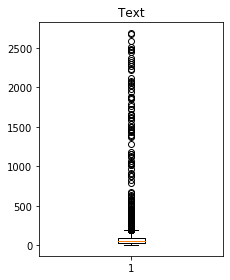

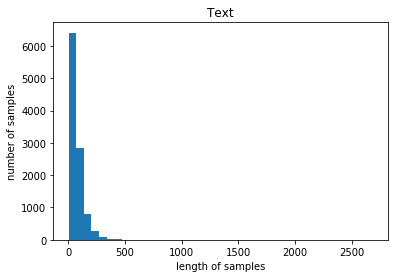

In [108]:
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [109]:
text_max_len = 150

텍스트의 최소 길이 : 29
텍스트의 최대 길이 : 98
텍스트의 평균 길이 : 77.82222222222222


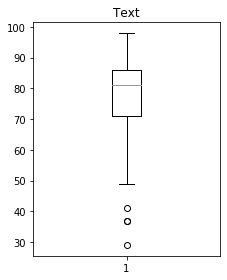

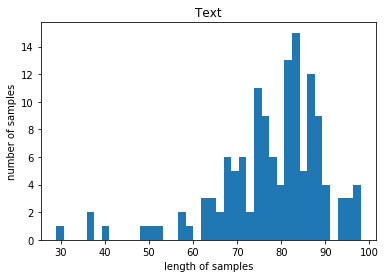

In [111]:
print('텍스트의 최소 길이 : {}'.format(np.min(seg_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(seg_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(seg_len)))

plt.subplot(1,2,1)
plt.boxplot(seg_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(seg_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [112]:
seg_max_len = 90

In [154]:
encoder_input = documents

In [155]:
decoder_input = list()
for doc in encoder_input:
    tmp = list()
    for x in doc:
        x = 'sostoken ' + x
        tmp.append(x)
    decoder_input.append(tmp)
    
decoder_target = list()
for doc in encoder_input:
    tmp = list()
    for x in doc:
        x = x + ' eostoken'
        tmp.append(x)
    decoder_target.append(tmp)

In [156]:
encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

/home/tako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/home/tako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/home/tako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant 

In [157]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[ 45  98  54 107 128 124 123  37  97  88 118  87  57  59  90 121  72  38
  31 104   9  50  94   3  60  77 100  61   6   1  23  86 132  95  53  27
  10  26  65  52  74 102  15  47  79   5  89  92   7  68 117 109   4 105
  20  62  96  14  42 106 131  76  82  11  64  55 130  13  19  32  56   8
  51 119  78  24 122  16  63 133  58  81  28 108  73  21  46  41  49  83
  43 111  71  70 110 115  22  75  99  39  85 125  66  44  12 101  69   2
  84  93  17  18  33 113  29  30 114 127 103  67  25  48 134 116  40  91
 120  35 112 129  80 126  34   0  36]


In [158]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 27


In [193]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [194]:
print(len(encoder_input_train))
print(len(decoder_input_train))
print(len(decoder_target_train))

108
108
108


In [195]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 108
훈련 레이블의 개수 : 108
테스트 데이터의 개수 : 27
테스트 레이블의 개수 : 27


In [196]:
encoder_total = list()
for doc in encoder_input_train:
    encoder_total.extend(doc)

In [197]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_total)

In [198]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 129279
등장 빈도가 6번 이하인 희귀 단어의 수: 118799
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10480
단어 집합에서 희귀 단어의 비율: 91.89350165146698
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 29.242224012892827


In [199]:
src_vocab = 110000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_total)

In [200]:
embeded_encoder_input_train = list()
for doc in encoder_input_train:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_encoder_input_train.append(doc)
encoder_input_train = embeded_encoder_input_train

embeded_encoder_input_test = list()
for doc in encoder_input_test:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_encoder_input_test.append(doc)
encoder_input_test = embeded_encoder_input_test

In [202]:
decoder_total = list()
for doc in decoder_input_train:
    decoder_total.extend(doc)
for doc in decoder_target_train:
    decoder_total.extend(doc)

In [203]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_total)

In [204]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 129281
등장 빈도가 5번 이하인 희귀 단어의 수: 103224
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 26057
단어 집합에서 희귀 단어의 비율: 79.84467941924954
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 19.06777572298822


In [205]:
tar_vocab = 110000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_total)

In [206]:
embeded_decoder_input_train = list()
for doc in decoder_input_train:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_decoder_input_train.append(doc)
decoder_input_train = embeded_decoder_input_train

embeded_decoder_input_test = list()
for doc in decoder_input_test:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_decoder_input_test.append(doc)
decoder_input_test = embeded_decoder_input_test

embeded_decoder_target_train = list()
for doc in decoder_target_train:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_decoder_target_train.append(doc)
decoder_target_train = embeded_decoder_target_train

embeded_decoder_target_test = list()
for doc in decoder_target_test:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_decoder_target_test.append(doc)
decoder_target_test = embeded_decoder_target_test

In [207]:
drop_train = [index for index, sentence in enumerate(doc) for doc in decoder_input_train if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(doc) for doc in decoder_input_test if len(sentence) == 1]

In [208]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 108
훈련 레이블의 개수 : 108
테스트 데이터의 개수 : 27
테스트 레이블의 개수 : 27


In [215]:
padded_sent_encoder_input_train = list()
for doc in encoder_input_train:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_encoder_input_train.append(doc)
encoder_input_train = padded_sent_encoder_input_train

padded_sent_encoder_input_test = list()
for doc in encoder_input_test:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_encoder_input_test.append(doc)
encoder_input_test = padded_sent_encoder_input_test

padded_sent_decoder_input_train = list()
for doc in decoder_input_train:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_input_train.append(doc)
decoder_input_train = padded_sent_decoder_input_train

padded_sent_decoder_target_train = list()
for doc in decoder_target_train:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_target_train.append(doc)
decoder_target_train = padded_sent_decoder_target_train

padded_sent_decoder_input_test = list()
for doc in decoder_input_test:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_input_test.append(doc)
decoder_input_test = padded_sent_decoder_input_test

padded_sent_decoder_target_test = list()
for doc in decoder_target_test:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_target_test.append(doc)
decoder_target_test = padded_sent_decoder_target_test

In [216]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = seg_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = seg_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = seg_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = seg_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = seg_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = seg_max_len, padding='post')

In [218]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [219]:
embedding_dim = 128
hidden_size = 256

In [220]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [253]:
# seg_max_len = 90
# text_max_len = 150
encoder_input_train[0].shape

(90, 150)

In [263]:
decoder_input_train[:, 0]

array([[26056,    41, 26057, ...,     0,     0,     0],
       [  306, 19060,   293, ...,   756,  8111,    23],
       [44366, 44367, 44368, ...,     0,     0,     0],
       ...,
       [ 2183, 16020,  7722, ...,     0,     0,     0],
       [27849, 37740,  1949, ...,     0,     0,     0],
       [ 6470,  4470,     1, ...,     0,     0,     0]], dtype=int32)

In [264]:
def autoencoder(hidden_size, text_max_len, src_vocab, tar_vocab, embedding_dim, name='autoencoder'):
    encoder_inputs = Input(shape=(seg_max_len, text_max_len, ))
    decoder_inputs = Input(shape=(None,))

    for t in range(encoder_inputs.shape[1]):
        # 인코더의 임베딩 층
        enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs[:, t])

        # 인코더의 LSTM 1
        encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
        encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

        # 인코더의 LSTM 2
        encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
        encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

        # 인코더의 LSTM 3
        encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
        encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
    
    
    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs[:, :, 0]) # 일단 책의 첫 문장 넣기 

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])
    
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input) 

    #return Model(inputs = [encoder_outputs, state_h, state_c, decoder_inputs], outputs = decoder_softmax_outputs)
    
    return Model([encoder_inputs, decoder_inputs], outputs = decoder_softmax_outputs)

In [265]:
model = autoencoder(hidden_size, text_max_len, src_vocab, tar_vocab, embedding_dim, name='autoencoder')

ValueError: Index out of range using input dim 2; input has only 2 dims for 'strided_slice_452' (op: 'StridedSlice') with input shapes: [?,?], [3], [3], [3] and with computed input tensors: input[3] = <1 1 1>.

In [ ]:
model.summary()



In [257]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [258]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 4, callbacks=[es], epochs = 50)

ValueError: Error when checking input: expected input_16 to have 2 dimensions, but got array with shape (108, 90, 150)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("예측 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


In [ ]:
model.save("novel_model1.h5")

In [ ]:
from keras.models import load_model
from attention import AttentionLayer
model = load_model("novel_model1.h5", custom_objects={'AttentionLayer':AttentionLayer})

In [ ]:
model.summary()